In [4]:
import os
import sys
import h5py
import pdb
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.io import loadmat

sys.path.insert(0, '../../../')
from ecg_AAAI.models.supervised.ecg_fi_model_keras import build_fi_model 
from ecg_AAAI.models.supervised.ecg_fc import build_fc_model
from ecg_AAAI.models.gpu_utils import restrict_GPU_keras
from ecg_AAAI.models.supervised.eval import evaluate_AUC, evaluate_HR, risk_scores
restrict_GPU_keras("3")

splits = ["0", "1", "2", "3", "4"]
day_threshs = [30, 60, 90, 365]
y_modes = ['mi', 'cvd']

def get_split_dir(split_num):
    return "/home/divyas/ecg_AAAI/datasets/splits/split_" + split_num

def get_labels(fhandle, y_mode, day_thresh):
    y = fhandle[y_mode + "_labels"][:]
    y = np.array([1 if (y_val < day_thresh and y_val > 0) else 0 for y_val in y])
    return y

Using GPU:3 with 0% of the memory


In [5]:
summary_dicts = []
day_thresh = 90
y_mode = 'cvd'
split_num = "0"
for y_mode in y_modes:
    for day_thresh in day_threshs:
        for split_num in splits:
            split_dir = get_split_dir(split_num)
            train_file = h5py.File(split_dir + "/train.h5", "r")
            test_file = h5py.File(split_dir + "/test.h5", "r")

            train_y = get_labels(train_file, y_mode, day_thresh)
            test_y = get_labels(test_file, y_mode, day_thresh)
            train_file.close()
            test_file.close()
            
            train_pct = len(train_y)/float((len(test_y) + len(train_y)))
            train_pos_pct = len(np.where(train_y != 0)[0])/float(len(train_y))
            train_neg_pct = 1 - train_pos_pct
            
            test_pct = 1 - train_pct
            test_pos_pct = len(np.where(test_y != 0)[0])/float(len(test_y))
            test_neg_pct = 1 - test_pos_pct
            n_train = len(train_y)
            n_test = len(test_y)
            
            
            
            summary_dict = {'split_num': split_num, 'day_thresh': day_thresh, 'y_mode': y_mode,
                            'n_test': n_test, 'n_train': n_train,
                            'test_pct': test_pct, 'train_pct': train_pct, 
                            'train_pos_pct': train_pos_pct, 'train_neg_pct': train_neg_pct,
                            'test_pos_pct': test_pos_pct, 'test_neg_pct': test_neg_pct}
            summary_dicts.append(summary_dict)
            pd.DataFrame(summary_dicts).to_csv('split_summary.csv')


In [6]:
split_df = pd.DataFrame(summary_dicts)
mi_day_means = split_df.groupby(['day_thresh', 'y_mode']).mean()
cvd_day_means = split_df[split_df['y_mode'] == 'cvd'].groupby('day_thresh').mean()
cvd_day_means = cvd_day_means.reset_index()
mi_day_means = mi_day_means.reset_index()
mi_day_means

,day_thresh,y_mode,n_test,n_train,test_neg_pct,test_pct,test_pos_pct,train_neg_pct,train_pct,train_pos_pct
0,30,cvd,1242.8,3732.2,0.984227,0.249809,0.015773,0.986496,0.750191,0.013504
1,30,mi,1242.8,3732.2,0.969274,0.249809,0.030726,0.967366,0.750191,0.032634
2,60,cvd,1242.8,3732.2,0.981167,0.249809,0.018833,0.981887,0.750191,0.018113
3,60,mi,1242.8,3732.2,0.961862,0.249809,0.038138,0.958309,0.750191,0.041691
4,90,cvd,1242.8,3732.2,0.978750,0.249809,0.021250,0.978939,0.750191,0.021061
5,90,mi,1242.8,3732.2,0.954136,0.249809,0.045864,0.949628,0.750191,0.050372
6,365,cvd,1242.8,3732.2,0.964264,0.249809,0.035736,0.962059,0.750191,0.037941
7,365,mi,1242.8,3732.2,0.929207,0.249809,0.070793,0.927926,0.750191,0.072074


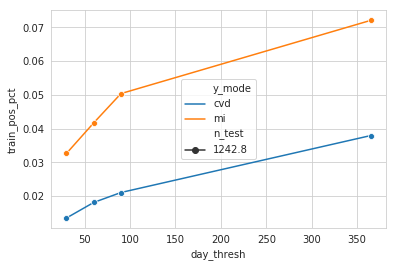

In [61]:
sns.lineplot(x='day_thresh', y='train_pos_pct', data=mi_day_means, 
             hue='y_mode', markers="o", style="n_test")


In [22]:
test_y = np.array(test_y)
train_y = np.array(train_y)

In [23]:
len(np.where(train_y != 0)[0])

77

In [15]:
split_dir = get_split_dir("1")
train_file = h5py.File(split_dir + "/train.h5", "r")
test_file = h5py.File(split_dir + "/test.h5", "r")

train_y = get_labels(train_file, y_mode, day_thresh)
test_y = get_labels(test_file, y_mode, day_thresh)
n_test = len(test_y)

train_neg_idx = np.where(train_y == 0)[0]
train_pos_idx = np.where(train_y == 1)[0]

In [19]:
train_file['adjacent_beats'][list(train_pos_idx)]

array([[[-0.15905552, -0.14633619, -0.12849441, ...,  0.00425655,
          0.00545905,  0.00745015],
        [-0.11978189, -0.09818985, -0.07531748, ...,  0.02095838,
          0.0261611 ,  0.03255974],
        [-0.16525627, -0.15800013, -0.14662811, ...,  0.00225208,
          0.00342445,  0.00480564],
        ...,
        [-0.10563887, -0.10349663, -0.09828647, ...,  0.02519004,
          0.02987784,  0.03537934],
        [-0.08435394, -0.08358793, -0.08048031, ...,  0.01098294,
          0.01306611,  0.01597459],
        [-0.11125682, -0.11180408, -0.11009636, ...,  0.00184058,
          0.00500869,  0.00907107]],

       [[-0.09443031, -0.09008664, -0.0840383 , ..., -0.00563019,
         -0.00499529, -0.00082276],
        [-0.09853156, -0.08761318, -0.07399973, ...,  0.00809348,
          0.01507048,  0.02445489],
        [-0.07020507, -0.05352657, -0.03269801, ...,  0.0139878 ,
          0.01700531,  0.02273551],
        ...,
        [-0.14000552, -0.14607646, -0.15512722, ...,  

In [21]:
split_df[split_df['split_num'] == "4"]

,day_thresh,n_test,n_train,split_num,test_neg_pct,test_pct,test_pos_pct,train_neg_pct,train_pct,train_pos_pct,y_mode
4,30,1239,3736,4,0.958838,0.249045,0.041162,0.970824,0.750955,0.029176,mi
9,60,1239,3736,4,0.949153,0.249045,0.050847,0.962527,0.750955,0.037473,mi
14,90,1239,3736,4,0.944310,0.249045,0.055690,0.952891,0.750955,0.047109,mi
19,365,1239,3736,4,0.920097,0.249045,0.079903,0.930942,0.750955,0.069058,mi
24,30,1239,3736,4,0.982244,0.249045,0.017756,0.987152,0.750955,0.012848,cvd
29,60,1239,3736,4,0.978208,0.249045,0.021792,0.982869,0.750955,0.017131,cvd
34,90,1239,3736,4,0.976594,0.249045,0.023406,0.979657,0.750955,0.020343,cvd
39,365,1239,3736,4,0.958838,0.249045,0.041162,0.963865,0.750955,0.036135,cvd
